In [41]:
# Additional imports
# -----
%pylab inline
import itertools
from time import time as wall_time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
# -----

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import scipy.sparse
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

Populating the interactive namespace from numpy and matplotlib


### Load data

In [3]:
data = np.load('glSN_timeseries_images_Doogesh.npz', allow_pickle=True)
images_normal = data['images_normal']
images_log = data['images_log']
time_stamps = data['time_stamps']

### Plot time-series images

In [5]:
def plot_observations(time_series, time_stamps):

    fig, ax = plt.subplots(4, 5, figsize=(15, 12))
    ax = ax.flatten()
    fig.suptitle("Observations", fontsize=25)

    for s in range(20):
        # Check if an observation exists
        if s < len(time_stamps):
            ax[s].matshow(time_series[s], origin='lower')
            ax[s].set_xticks([])
            ax[s].set_yticks([])
            ax[s].set_title("t = " + str(int(np.around(time_stamps[s], 0))) + " days", fontsize=18)
        else:
            ax[s].set_aspect('equal')

    plt.show()

Normal:


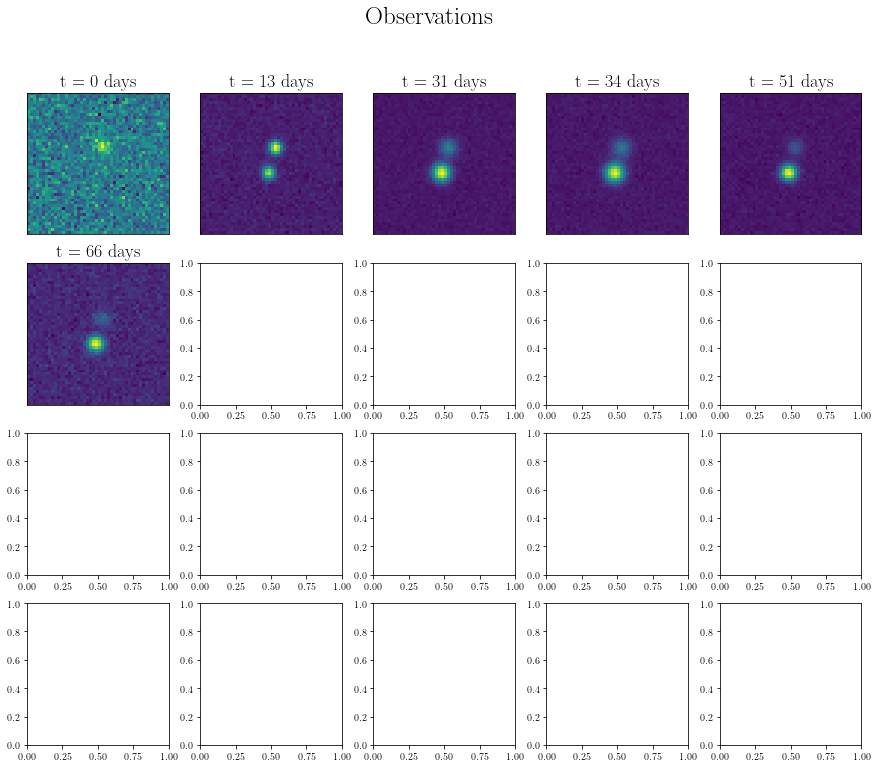

In [32]:
index = 9
print("Normal:")
plot_observations(images_normal[index], time_stamps[index])


### SME algorithm

In [8]:
def softplus(x, k=0.125, a=1.e-3, b=40.):
    return np.log(1 + np.sqrt(a*np.exp(k*(x-b))))/k

In [9]:
def SME(image_stack):

    # Initialisation
    image_stack = np.array(image_stack)
    D = image_stack.shape[0] # Depth
    N = 48 # equivalent to W and H
    T = D/100
    epsilon = 1.2e-2 #5e-3
    delta_T = 0.99
    MIP = image_stack.max(axis=0) # Maximum intensity projection
    Z_max = np.argmax(image_stack, axis=0) # initial guess is basically Z-index map corresponding to MIP
    Z_old = Z_max.copy()
    Z_old = Z_old.astype(np.float64)
    converged = False
    
    # Iterative scheme
    n_iter = 0 # corresponds to t = 1
    Z_new = np.zeros([N,N])
    loss = []
    loss_old = 1e3

    while not converged:
        loss_iter = 0
        Z_perturb = Z_old.copy()
        for (i,j) in itertools.product(range(N),range(N)):
            norm_iter = []
            stored_values = []
            # There are three shifts here, with sigma_local computed for each shift
            for step in [-T,0,T]:
                Z_perturb[i,j] = Z_old[i,j] + step
                if Z_perturb[i,j] < 0:
                    Z_perturb[i,j] = max(Z_perturb[i,j],0)
                if Z_perturb[i,j] > D:
                    Z_perturb[i,j] = min(Z_perturb[i,j],D)
                # Compute local spatial sigma (3x3 window with boundary conditions)
                sigma_local = np.std(Z_perturb[max(i-1,0):min(i+2,N),max(j-1,0):min(j+2,N)])
                norm_iter.append(softplus(MIP[i,j])*np.abs(Z_max[i,j] - Z_perturb[i,j]) + sigma_local)
                stored_values.append(Z_perturb[i,j])
            norm_iter = np.array(norm_iter)
            stored_values = np.array(stored_values)
            Z_new[i,j] = stored_values[np.argmin(norm_iter)]
            loss_iter += norm_iter.min()

        conv_norm = np.linalg.norm(Z_old - Z_new)/np.linalg.norm(Z_old)
        loss.append(loss_iter)
        if conv_norm < epsilon:
            converged = True
        Z_old = Z_new.copy()
        loss_old = loss_iter
        T *= delta_T
        n_iter += 1

    Z_new = np.round(Z_new)
    Z_new = Z_new.astype(np.int32)
    SME_ = np.zeros([N,N])
    for (i,j) in itertools.product(range(N),range(N)):
        SME_[i,j] = image_stack[Z_new[i,j],i,j]
    return SME_, Z_new, MIP, Z_max

### Testing on some individual samples

In [37]:
idx = 2
start = wall_time()
SME2, Z_new2, MIP2, Z_max2 = SME(images_normal[idx][:time_stamps[idx].size])
end = wall_time()
print("Time elapsed: ", end - start, "seconds")

Time elapsed:  6.913434028625488 seconds


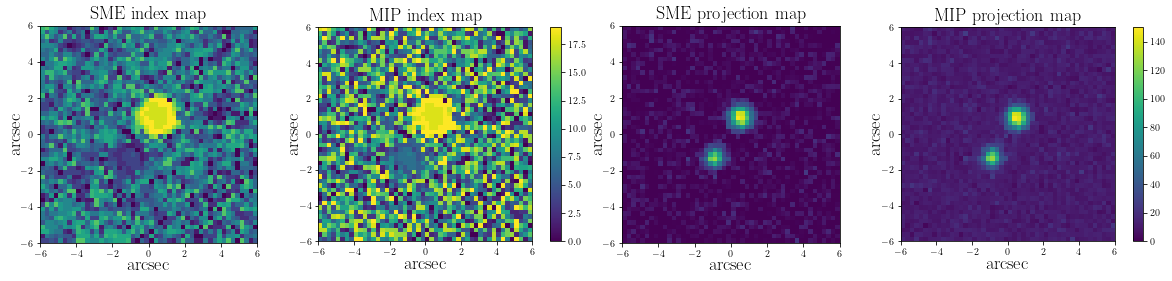

In [40]:
fig, ax = subplots(1, 4, figsize=(20,4), sharex=False, sharey=False)

patch_size = 48*0.25
ax0 = ax[0].imshow(Z_new2, origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="viridis");
ax[0].set_xlabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-1);
ax[0].set_ylabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-3);
ax[0].set_title(r"$\mathrm{SME \ index \ map}$", fontsize=18);

divider = make_axes_locatable(ax[0]);

ax1 = ax[1].imshow(Z_max2, origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="viridis");
ax[1].set_xlabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-1);
ax[1].set_ylabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-3);
ax[1].set_title(r"$\mathrm{MIP \ index \ map}$", fontsize=18);

divider = make_axes_locatable(ax[1]);
cax = divider.append_axes("right", size="5%", pad=0.25);
fig.colorbar(ax1, cax=cax);

patch_size = 48*0.25
ax2 = ax[2].imshow(SME2, origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="viridis", vmin=0, vmax=150);
ax[2].set_xlabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-1);
ax[2].set_ylabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-3);
ax[2].set_title(r"$\mathrm{SME \ projection \ map}$", fontsize=18);

divider = make_axes_locatable(ax[2]);

ax3 = ax[3].imshow(MIP2, origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="viridis", vmin=0, vmax=150);
ax[3].set_xlabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-1);
ax[3].set_ylabel(r"$\mathrm{arcsec}$", fontsize=18, labelpad=-3);
ax[3].set_title(r"$\mathrm{MIP \ projection \ map}$", fontsize=18);

divider = make_axes_locatable(ax[3]);
cax = divider.append_axes("right", size="5%", pad=0.25);
fig.colorbar(ax3, cax=cax);

#f.savefig("SME_MIP_maps.pdf", bbox_inches="tight")

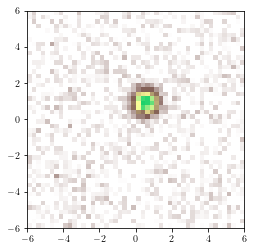

In [194]:
imshow(images_normal[idx][-1], origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="terrain_r", vmin=0, vmax=150);

### Loop to compute SME for all systems

In [195]:
NumSamples = images_normal.shape[0]
images_SME = []

for i in tqdm(range(NumSamples)):
    images_SME.append(SME(images_normal[i][:time_stamps[i].size])[0])

100%|██████████| 50/50 [07:33<00:00,  9.07s/it]


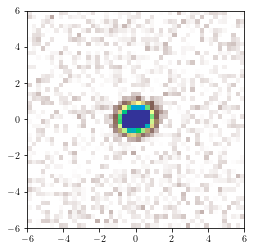

In [154]:
imshow(images_SME[0], origin='lower', extent=(-patch_size/2,patch_size/2,-patch_size/2,patch_size/2), cmap="terrain_r", vmin=0, vmax=150);

In [196]:
# Execution time for 10k samples

(9.1*10000)/3600

25.27777777777778

In [22]:
print(np.shape(Z_new2))
print(np.shape(images_normal[index]))
print(np.shape(Z_new2.choose(images_normal[index])))

(48, 48)
(20, 48, 48)
(48, 48)


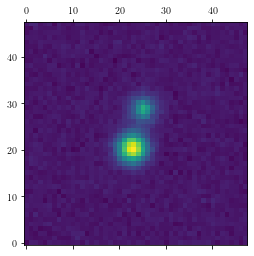

In [35]:
matshow(SME2, origin='lower')

### Use on large dataset

In [48]:
data_path = 'Cadence_trainingset_doubles/'
start = 0
end = 1
L_limit = 20
N_images = 2
dt_lower_cut = 2
dt_upper_cut = 150
mag_cut = 23.9
size = 5
param = 'dt'


# -------- Read in data --------
files = sorted([f for f in os.listdir(data_path) if not f.startswith('.') if f.endswith(".pkl")
                if os.path.isfile(os.path.join(data_path, f))],
               key=lambda f: f.lower())[start:end]

df = pd.concat([pd.read_pickle(data_path + x) for x in files], ignore_index=True)

data_images = df['time_series'].to_numpy()[:size]
time_delay_distance = df['time_delay_distance'].to_numpy()[:size]
time_stamps = df['time_stamps'].to_numpy()[:size]

In [49]:
NumSamples = data_images.shape[0]
images_SME = []

for i in tqdm(range(NumSamples)):
    images_SME.append(SME(data_images[i][:time_stamps[i].size])[0])
    


  0%|          | 0/5 [00:00<?, ?it/s]

9


 20%|██        | 1/5 [00:07<00:30,  7.64s/it]

11


 40%|████      | 2/5 [00:15<00:22,  7.65s/it]

18


 60%|██████    | 3/5 [00:22<00:14,  7.43s/it]

20


 80%|████████  | 4/5 [00:29<00:07,  7.25s/it]

13


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


In [57]:
print((images_SME[0]))

[[  4.58248719   7.6961847    0.63251795 ...  -0.91947182  -2.56098668
    9.42655703]
 [  8.50469132  15.31205876   4.3260374  ...   7.61373687  -1.85049799
   -3.1109114 ]
 [  4.14232821  -6.01565819   8.16051473 ...   7.44256418   1.52791892
   -6.99005699]
 ...
 [ 17.69548818   2.03849023   1.8772888  ...  -1.67961099  -6.19488175
   13.34931748]
 [ -4.038668   -10.49052993   1.32727655 ...   4.77764951  -4.59825526
   -3.6093557 ]
 [-10.71618395  -0.06631387   1.08628573 ...   2.14632118  -0.56498988
   -2.27020234]]


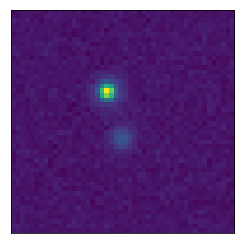

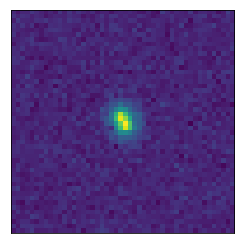

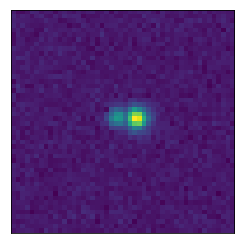

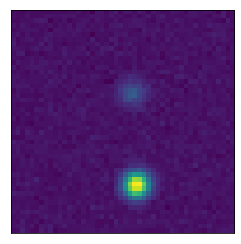

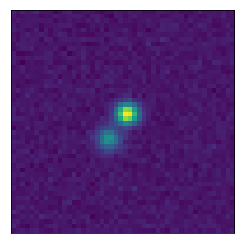

In [56]:
for i in range(5):
    matshow(images_SME[i], origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.show()